In [1]:
# install libs if necessary
# !pip install hachoir pillow

In [32]:
# imports
from hachoir.stream import FileInputStream, InputIOStream
from hachoir.parser import guessParser, HachoirParserList
from hachoir.core.tools import humanFilesize, humanBitSize, makePrintable
from hachoir.core.endian import BIG_ENDIAN, LITTLE_ENDIAN
from PIL import Image
import io
from hachoir.core import config
# don't display warnings
config.quiet = True
# be verbose about parsers tried, etc. 
config.verbose=False

In [3]:
# utility functions

# fields are loaded lazily, so we won't have them unless we traverse them
# recursive function to get all fields
def displayTree(parent):
    for field in parent:
        print(field.path)
        if field.is_field_set: displayTree(field)

# print interesting bits of a parsed field            
def displayField(afield):
    print(f"{int(afield.address/8)} --> {afield.name} {afield.description} {afield.display} {type(afield)} {afield.raw_display}")            

In [4]:
# here's the list of parsers Hachoir has
[e for e in HachoirParserList()]

[hachoir.parser.archive.ace.AceFile,
 hachoir.parser.archive.ar.ArchiveFile,
 hachoir.parser.archive.bomstore.BomFile,
 hachoir.parser.archive.bzip2_parser.Bzip2Parser,
 hachoir.parser.archive.cab.CabFile,
 hachoir.parser.archive.gzip_parser.GzipParser,
 hachoir.parser.archive.mar.MarFile,
 hachoir.parser.archive.mozilla_ar.MozillaArchive,
 hachoir.parser.archive.prs_pak.PRSPakFile,
 hachoir.parser.archive.rar.RarFile,
 hachoir.parser.archive.rpm.RpmFile,
 hachoir.parser.archive.sevenzip.SevenZipParser,
 hachoir.parser.archive.tar.TarFile,
 hachoir.parser.archive.zip.ZipFile,
 hachoir.parser.archive.zlib.ZlibData,
 hachoir.parser.audio.aiff.AiffFile,
 hachoir.parser.audio.mod.AmigaModule,
 hachoir.parser.audio.au.AuFile,
 hachoir.parser.audio.flac.FlacParser,
 hachoir.parser.audio.itunesdb.ITunesDBFile,
 hachoir.parser.audio.midi.MidiFile,
 hachoir.parser.audio.mpeg_audio.MpegAudioFile,
 hachoir.parser.audio.s3m.PTMModule,
 hachoir.parser.audio.real_audio.RealAudioFile,
 hachoir.parser

In [5]:
# see if we know what a binary blob of something is
target='/Users/jeff/work/ablob_of_who_knows_what'
astream=FileInputStream(target)
parser = guessParser(astream)
print(parser)

None


In [6]:
# wild guess, do we recognize it by sight? 
io.open(target,"rb").read(10).hex()

'e063fd9406fa36abd187'

In [7]:
# step through the file to see if we can recognize a portion of it
view=io.BytesIO(io.open(target,"rb").read()).getbuffer()

# step through the first x of the file 8 bits at a time looking for recognized files
for x in range(0,4096,8):
    parser=guessParser(InputIOStream(io.BytesIO(view[x::])))
    if parser:
        print(f"{parser} found at position {x}")


<GifFile path=/, current_size=104, current length=3> found at position 512


In [8]:
# do we recognize this?
print(view[512:520].tobytes())

b'GIF89a\x0e\x01'


In [9]:
# re-init our 'parser' variable
# now that we found our target

parser=guessParser(InputIOStream(io.BytesIO(view[512::])))
print (parser)

<GifFile path=/, current_size=104, current length=3>


In [10]:
# if we like, we could write it out assuming the rest of the file is just the .gif
# (but if it's a giant stream, like a disk image.. we don't want to do this)
f=open('/Users/jeff/work/a-gif-we-found.gif','wb')
f.write(io.BytesIO(view[512::]).getvalue())
f.close()

In [ ]:
# know that we know the offset
# we could also open the file at that point using the FileInputStream hachoir class
# commented out, lets carry on with just the parser of raw blob

# parser = guessParser(FileInputStream('/Users/jeff/work/ablob_of_who_knows_what',offset=512))
# print(parser)

In [11]:
#tags are name/value pairs that hachoir uses internally to process 
parser.getParserTags()

{'id': 'gif',
 'category': 'image',
 'file_ext': ('gif',),
 'mime': ('image/gif',),
 'min_size': 184,
 'magic': ((b'GIF87a', 0), (b'GIF89a', 0)),
 'description': 'GIF picture'}

In [12]:
# a gif!
# reference:
# https://www.matthewflickinger.com/lab/whatsinagif/bits_and_bytes.asp

In [13]:
# parser field reference: 
# https://hachoir.readthedocs.io/en/latest/developer.html#field-class

# lets see what fields the GIF parser knows about
for field in parser:
    print(f"{int(field.address/8)} --> {field.name} {field.description} {type(field)}")


0 --> magic File magic code <class 'hachoir.field.string_field.String'>
3 --> version GIF version <class 'hachoir.field.string_field.String'>
6 --> screen Screen descriptor: 270x378 pixels 256 colors <class 'hachoir.parser.image.gif.ScreenDescriptor'>
13 --> color_map Color map <class 'hachoir.parser.image.common.PaletteRGB'>
781 --> separator[0] Separator code <class 'hachoir.field.character.Character'>
782 --> app_ext[0] Application extension <class 'hachoir.parser.image.gif.Extension'>
800 --> separator[1] Separator code <class 'hachoir.field.character.Character'>
801 --> app_ext[1] Application extension <class 'hachoir.parser.image.gif.Extension'>
1852 --> separator[2] Separator code <class 'hachoir.field.character.Character'>
1853 --> graphic_ctl[0] Graphic control <class 'hachoir.parser.image.gif.Extension'>
1860 --> separator[3] Separator code <class 'hachoir.field.character.Character'>
1861 --> image[0] Image: 270x378 pixels at (0,0) <class 'hachoir.parser.image.gif.Image'>
628

1566699 --> image[26] Image: 270x378 pixels at (0,0) <class 'hachoir.parser.image.gif.Image'>
1626807 --> separator[56] Separator code <class 'hachoir.field.character.Character'>
1626808 --> graphic_ctl[27] Graphic control <class 'hachoir.parser.image.gif.Extension'>
1626815 --> separator[57] Separator code <class 'hachoir.field.character.Character'>
1626816 --> image[27] Image: 270x378 pixels at (0,0) <class 'hachoir.parser.image.gif.Image'>
1687063 --> separator[58] Separator code <class 'hachoir.field.character.Character'>
1687064 --> graphic_ctl[28] Graphic control <class 'hachoir.parser.image.gif.Extension'>
1687071 --> separator[59] Separator code <class 'hachoir.field.character.Character'>
1687072 --> image[28] Image: 270x378 pixels at (0,0) <class 'hachoir.parser.image.gif.Image'>
1747620 --> separator[60] Separator code <class 'hachoir.field.character.Character'>
1747621 --> graphic_ctl[29] Graphic control <class 'hachoir.parser.image.gif.Extension'>
1747628 --> separator[61] 

In [14]:
# lets see what fields and subfields we have 
displayTree(parser)

/magic
/version
/screen
/screen/width
/screen/height
/screen/size_global_map
/screen/sort_flag
/screen/color_res
/screen/global_map
/screen/background
/screen/pixel_aspect_ratio
/color_map
/color_map/color[0]
/color_map/color[0]/red
/color_map/color[0]/green
/color_map/color[0]/blue
/color_map/color[1]
/color_map/color[1]/red
/color_map/color[1]/green
/color_map/color[1]/blue
/color_map/color[2]
/color_map/color[2]/red
/color_map/color[2]/green
/color_map/color[2]/blue
/color_map/color[3]
/color_map/color[3]/red
/color_map/color[3]/green
/color_map/color[3]/blue
/color_map/color[4]
/color_map/color[4]/red
/color_map/color[4]/green
/color_map/color[4]/blue
/color_map/color[5]
/color_map/color[5]/red
/color_map/color[5]/green
/color_map/color[5]/blue
/color_map/color[6]
/color_map/color[6]/red
/color_map/color[6]/green
/color_map/color[6]/blue
/color_map/color[7]
/color_map/color[7]/red
/color_map/color[7]/green
/color_map/color[7]/blue
/color_map/color[8]
/color_map/color[8]/red
/color_

/image[0]/image_block[221]/rawdata
/image[0]/image_block_size[222]
/image[0]/image_block[222]
/image[0]/image_block[222]/rawdata
/image[0]/image_block_size[223]
/image[0]/image_block[223]
/image[0]/image_block[223]/rawdata
/image[0]/image_block_size[224]
/image[0]/image_block[224]
/image[0]/image_block[224]/rawdata
/image[0]/image_block_size[225]
/image[0]/image_block[225]
/image[0]/image_block[225]/rawdata
/image[0]/image_block_size[226]
/image[0]/image_block[226]
/image[0]/image_block[226]/rawdata
/image[0]/image_block_size[227]
/image[0]/image_block[227]
/image[0]/image_block[227]/rawdata
/image[0]/image_block_size[228]
/image[0]/image_block[228]
/image[0]/image_block[228]/rawdata
/image[0]/image_block_size[229]
/image[0]/image_block[229]
/image[0]/image_block[229]/rawdata
/image[0]/image_block_size[230]
/image[0]/image_block[230]
/image[0]/image_block[230]/rawdata
/image[0]/image_block_size[231]
/image[0]/image_block[231]
/image[0]/image_block[231]/rawdata
/image[0]/image_block_siz

/image[2]/image_block[228]/rawdata
/image[2]/image_block_size[229]
/image[2]/image_block[229]
/image[2]/image_block[229]/rawdata
/image[2]/image_block_size[230]
/image[2]/image_block[230]
/image[2]/image_block[230]/rawdata
/image[2]/image_block_size[231]
/image[2]/image_block[231]
/image[2]/image_block[231]/rawdata
/image[2]/image_block_size[232]
/image[2]/image_block[232]
/image[2]/image_block[232]/rawdata
/image[2]/image_block_size[233]
/image[2]/image_block[233]
/image[2]/image_block[233]/rawdata
/image[2]/image_block_size[234]
/image[2]/image_block[234]
/image[2]/image_block[234]/rawdata
/image[2]/terminator
/separator[8]
/graphic_ctl[3]
/graphic_ctl[3]/code
/graphic_ctl[3]/size
/graphic_ctl[3]/has_transp
/graphic_ctl[3]/user_input
/graphic_ctl[3]/disposal_method
/graphic_ctl[3]/reserved[0]
/graphic_ctl[3]/delay
/graphic_ctl[3]/transp
/graphic_ctl[3]/terminator
/separator[9]
/image[3]
/image[3]/left
/image[3]/top
/image[3]/width
/image[3]/height
/image[3]/size_local_map
/image[3]/r

/graphic_ctl[5]/size
/graphic_ctl[5]/has_transp
/graphic_ctl[5]/user_input
/graphic_ctl[5]/disposal_method
/graphic_ctl[5]/reserved[0]
/graphic_ctl[5]/delay
/graphic_ctl[5]/transp
/graphic_ctl[5]/terminator
/separator[13]
/image[5]
/image[5]/left
/image[5]/top
/image[5]/width
/image[5]/height
/image[5]/size_local_map
/image[5]/reserved
/image[5]/sort_flag
/image[5]/interlaced
/image[5]/has_local_map
/image[5]/lzw_min_code_size
/image[5]/image_block_size[0]
/image[5]/image_block[0]
/image[5]/image_block[0]/rawdata
/image[5]/image_block_size[1]
/image[5]/image_block[1]
/image[5]/image_block[1]/rawdata
/image[5]/image_block_size[2]
/image[5]/image_block[2]
/image[5]/image_block[2]/rawdata
/image[5]/image_block_size[3]
/image[5]/image_block[3]
/image[5]/image_block[3]/rawdata
/image[5]/image_block_size[4]
/image[5]/image_block[4]
/image[5]/image_block[4]/rawdata
/image[5]/image_block_size[5]
/image[5]/image_block[5]
/image[5]/image_block[5]/rawdata
/image[5]/image_block_size[6]
/image[5]/i

/image[7]/image_block[4]
/image[7]/image_block[4]/rawdata
/image[7]/image_block_size[5]
/image[7]/image_block[5]
/image[7]/image_block[5]/rawdata
/image[7]/image_block_size[6]
/image[7]/image_block[6]
/image[7]/image_block[6]/rawdata
/image[7]/image_block_size[7]
/image[7]/image_block[7]
/image[7]/image_block[7]/rawdata
/image[7]/image_block_size[8]
/image[7]/image_block[8]
/image[7]/image_block[8]/rawdata
/image[7]/image_block_size[9]
/image[7]/image_block[9]
/image[7]/image_block[9]/rawdata
/image[7]/image_block_size[10]
/image[7]/image_block[10]
/image[7]/image_block[10]/rawdata
/image[7]/image_block_size[11]
/image[7]/image_block[11]
/image[7]/image_block[11]/rawdata
/image[7]/image_block_size[12]
/image[7]/image_block[12]
/image[7]/image_block[12]/rawdata
/image[7]/image_block_size[13]
/image[7]/image_block[13]
/image[7]/image_block[13]/rawdata
/image[7]/image_block_size[14]
/image[7]/image_block[14]
/image[7]/image_block[14]/rawdata
/image[7]/image_block_size[15]
/image[7]/image_

/image[9]/image_block_size[17]
/image[9]/image_block[17]
/image[9]/image_block[17]/rawdata
/image[9]/image_block_size[18]
/image[9]/image_block[18]
/image[9]/image_block[18]/rawdata
/image[9]/image_block_size[19]
/image[9]/image_block[19]
/image[9]/image_block[19]/rawdata
/image[9]/image_block_size[20]
/image[9]/image_block[20]
/image[9]/image_block[20]/rawdata
/image[9]/image_block_size[21]
/image[9]/image_block[21]
/image[9]/image_block[21]/rawdata
/image[9]/image_block_size[22]
/image[9]/image_block[22]
/image[9]/image_block[22]/rawdata
/image[9]/image_block_size[23]
/image[9]/image_block[23]
/image[9]/image_block[23]/rawdata
/image[9]/image_block_size[24]
/image[9]/image_block[24]
/image[9]/image_block[24]/rawdata
/image[9]/image_block_size[25]
/image[9]/image_block[25]
/image[9]/image_block[25]/rawdata
/image[9]/image_block_size[26]
/image[9]/image_block[26]
/image[9]/image_block[26]/rawdata
/image[9]/image_block_size[27]
/image[9]/image_block[27]
/image[9]/image_block[27]/rawdata

/image[11]/image_block_size[31]
/image[11]/image_block[31]
/image[11]/image_block[31]/rawdata
/image[11]/image_block_size[32]
/image[11]/image_block[32]
/image[11]/image_block[32]/rawdata
/image[11]/image_block_size[33]
/image[11]/image_block[33]
/image[11]/image_block[33]/rawdata
/image[11]/image_block_size[34]
/image[11]/image_block[34]
/image[11]/image_block[34]/rawdata
/image[11]/image_block_size[35]
/image[11]/image_block[35]
/image[11]/image_block[35]/rawdata
/image[11]/image_block_size[36]
/image[11]/image_block[36]
/image[11]/image_block[36]/rawdata
/image[11]/image_block_size[37]
/image[11]/image_block[37]
/image[11]/image_block[37]/rawdata
/image[11]/image_block_size[38]
/image[11]/image_block[38]
/image[11]/image_block[38]/rawdata
/image[11]/image_block_size[39]
/image[11]/image_block[39]
/image[11]/image_block[39]/rawdata
/image[11]/image_block_size[40]
/image[11]/image_block[40]
/image[11]/image_block[40]/rawdata
/image[11]/image_block_size[41]
/image[11]/image_block[41]
/

/image[13]/image_block[45]/rawdata
/image[13]/image_block_size[46]
/image[13]/image_block[46]
/image[13]/image_block[46]/rawdata
/image[13]/image_block_size[47]
/image[13]/image_block[47]
/image[13]/image_block[47]/rawdata
/image[13]/image_block_size[48]
/image[13]/image_block[48]
/image[13]/image_block[48]/rawdata
/image[13]/image_block_size[49]
/image[13]/image_block[49]
/image[13]/image_block[49]/rawdata
/image[13]/image_block_size[50]
/image[13]/image_block[50]
/image[13]/image_block[50]/rawdata
/image[13]/image_block_size[51]
/image[13]/image_block[51]
/image[13]/image_block[51]/rawdata
/image[13]/image_block_size[52]
/image[13]/image_block[52]
/image[13]/image_block[52]/rawdata
/image[13]/image_block_size[53]
/image[13]/image_block[53]
/image[13]/image_block[53]/rawdata
/image[13]/image_block_size[54]
/image[13]/image_block[54]
/image[13]/image_block[54]/rawdata
/image[13]/image_block_size[55]
/image[13]/image_block[55]
/image[13]/image_block[55]/rawdata
/image[13]/image_block_si

/image[15]/image_block[59]/rawdata
/image[15]/image_block_size[60]
/image[15]/image_block[60]
/image[15]/image_block[60]/rawdata
/image[15]/image_block_size[61]
/image[15]/image_block[61]
/image[15]/image_block[61]/rawdata
/image[15]/image_block_size[62]
/image[15]/image_block[62]
/image[15]/image_block[62]/rawdata
/image[15]/image_block_size[63]
/image[15]/image_block[63]
/image[15]/image_block[63]/rawdata
/image[15]/image_block_size[64]
/image[15]/image_block[64]
/image[15]/image_block[64]/rawdata
/image[15]/image_block_size[65]
/image[15]/image_block[65]
/image[15]/image_block[65]/rawdata
/image[15]/image_block_size[66]
/image[15]/image_block[66]
/image[15]/image_block[66]/rawdata
/image[15]/image_block_size[67]
/image[15]/image_block[67]
/image[15]/image_block[67]/rawdata
/image[15]/image_block_size[68]
/image[15]/image_block[68]
/image[15]/image_block[68]/rawdata
/image[15]/image_block_size[69]
/image[15]/image_block[69]
/image[15]/image_block[69]/rawdata
/image[15]/image_block_si

/image[17]/image_block[74]
/image[17]/image_block[74]/rawdata
/image[17]/image_block_size[75]
/image[17]/image_block[75]
/image[17]/image_block[75]/rawdata
/image[17]/image_block_size[76]
/image[17]/image_block[76]
/image[17]/image_block[76]/rawdata
/image[17]/image_block_size[77]
/image[17]/image_block[77]
/image[17]/image_block[77]/rawdata
/image[17]/image_block_size[78]
/image[17]/image_block[78]
/image[17]/image_block[78]/rawdata
/image[17]/image_block_size[79]
/image[17]/image_block[79]
/image[17]/image_block[79]/rawdata
/image[17]/image_block_size[80]
/image[17]/image_block[80]
/image[17]/image_block[80]/rawdata
/image[17]/image_block_size[81]
/image[17]/image_block[81]
/image[17]/image_block[81]/rawdata
/image[17]/image_block_size[82]
/image[17]/image_block[82]
/image[17]/image_block[82]/rawdata
/image[17]/image_block_size[83]
/image[17]/image_block[83]
/image[17]/image_block[83]/rawdata
/image[17]/image_block_size[84]
/image[17]/image_block[84]
/image[17]/image_block[84]/rawdat

/image[19]/image_block[89]
/image[19]/image_block[89]/rawdata
/image[19]/image_block_size[90]
/image[19]/image_block[90]
/image[19]/image_block[90]/rawdata
/image[19]/image_block_size[91]
/image[19]/image_block[91]
/image[19]/image_block[91]/rawdata
/image[19]/image_block_size[92]
/image[19]/image_block[92]
/image[19]/image_block[92]/rawdata
/image[19]/image_block_size[93]
/image[19]/image_block[93]
/image[19]/image_block[93]/rawdata
/image[19]/image_block_size[94]
/image[19]/image_block[94]
/image[19]/image_block[94]/rawdata
/image[19]/image_block_size[95]
/image[19]/image_block[95]
/image[19]/image_block[95]/rawdata
/image[19]/image_block_size[96]
/image[19]/image_block[96]
/image[19]/image_block[96]/rawdata
/image[19]/image_block_size[97]
/image[19]/image_block[97]
/image[19]/image_block[97]/rawdata
/image[19]/image_block_size[98]
/image[19]/image_block[98]
/image[19]/image_block[98]/rawdata
/image[19]/image_block_size[99]
/image[19]/image_block[99]
/image[19]/image_block[99]/rawdat

/image[21]/image_block_size[103]
/image[21]/image_block[103]
/image[21]/image_block[103]/rawdata
/image[21]/image_block_size[104]
/image[21]/image_block[104]
/image[21]/image_block[104]/rawdata
/image[21]/image_block_size[105]
/image[21]/image_block[105]
/image[21]/image_block[105]/rawdata
/image[21]/image_block_size[106]
/image[21]/image_block[106]
/image[21]/image_block[106]/rawdata
/image[21]/image_block_size[107]
/image[21]/image_block[107]
/image[21]/image_block[107]/rawdata
/image[21]/image_block_size[108]
/image[21]/image_block[108]
/image[21]/image_block[108]/rawdata
/image[21]/image_block_size[109]
/image[21]/image_block[109]
/image[21]/image_block[109]/rawdata
/image[21]/image_block_size[110]
/image[21]/image_block[110]
/image[21]/image_block[110]/rawdata
/image[21]/image_block_size[111]
/image[21]/image_block[111]
/image[21]/image_block[111]/rawdata
/image[21]/image_block_size[112]
/image[21]/image_block[112]
/image[21]/image_block[112]/rawdata
/image[21]/image_block_size[11

/image[23]/image_block[135]/rawdata
/image[23]/image_block_size[136]
/image[23]/image_block[136]
/image[23]/image_block[136]/rawdata
/image[23]/image_block_size[137]
/image[23]/image_block[137]
/image[23]/image_block[137]/rawdata
/image[23]/image_block_size[138]
/image[23]/image_block[138]
/image[23]/image_block[138]/rawdata
/image[23]/image_block_size[139]
/image[23]/image_block[139]
/image[23]/image_block[139]/rawdata
/image[23]/image_block_size[140]
/image[23]/image_block[140]
/image[23]/image_block[140]/rawdata
/image[23]/image_block_size[141]
/image[23]/image_block[141]
/image[23]/image_block[141]/rawdata
/image[23]/image_block_size[142]
/image[23]/image_block[142]
/image[23]/image_block[142]/rawdata
/image[23]/image_block_size[143]
/image[23]/image_block[143]
/image[23]/image_block[143]/rawdata
/image[23]/image_block_size[144]
/image[23]/image_block[144]
/image[23]/image_block[144]/rawdata
/image[23]/image_block_size[145]
/image[23]/image_block[145]
/image[23]/image_block[145]/ra

/image[25]/image_block[232]/rawdata
/image[25]/image_block_size[233]
/image[25]/image_block[233]
/image[25]/image_block[233]/rawdata
/image[25]/image_block_size[234]
/image[25]/image_block[234]
/image[25]/image_block[234]/rawdata
/image[25]/image_block_size[235]
/image[25]/image_block[235]
/image[25]/image_block[235]/rawdata
/image[25]/image_block_size[236]
/image[25]/image_block[236]
/image[25]/image_block[236]/rawdata
/image[25]/terminator
/separator[54]
/graphic_ctl[26]
/graphic_ctl[26]/code
/graphic_ctl[26]/size
/graphic_ctl[26]/has_transp
/graphic_ctl[26]/user_input
/graphic_ctl[26]/disposal_method
/graphic_ctl[26]/reserved[0]
/graphic_ctl[26]/delay
/graphic_ctl[26]/transp
/graphic_ctl[26]/terminator
/separator[55]
/image[26]
/image[26]/left
/image[26]/top
/image[26]/width
/image[26]/height
/image[26]/size_local_map
/image[26]/reserved
/image[26]/sort_flag
/image[26]/interlaced
/image[26]/has_local_map
/image[26]/lzw_min_code_size
/image[26]/image_block_size[0]
/image[26]/image_bl

/image[27]/image_block[145]/rawdata
/image[27]/image_block_size[146]
/image[27]/image_block[146]
/image[27]/image_block[146]/rawdata
/image[27]/image_block_size[147]
/image[27]/image_block[147]
/image[27]/image_block[147]/rawdata
/image[27]/image_block_size[148]
/image[27]/image_block[148]
/image[27]/image_block[148]/rawdata
/image[27]/image_block_size[149]
/image[27]/image_block[149]
/image[27]/image_block[149]/rawdata
/image[27]/image_block_size[150]
/image[27]/image_block[150]
/image[27]/image_block[150]/rawdata
/image[27]/image_block_size[151]
/image[27]/image_block[151]
/image[27]/image_block[151]/rawdata
/image[27]/image_block_size[152]
/image[27]/image_block[152]
/image[27]/image_block[152]/rawdata
/image[27]/image_block_size[153]
/image[27]/image_block[153]
/image[27]/image_block[153]/rawdata
/image[27]/image_block_size[154]
/image[27]/image_block[154]
/image[27]/image_block[154]/rawdata
/image[27]/image_block_size[155]
/image[27]/image_block[155]
/image[27]/image_block[155]/ra

/image[29]/image_block[156]
/image[29]/image_block[156]/rawdata
/image[29]/image_block_size[157]
/image[29]/image_block[157]
/image[29]/image_block[157]/rawdata
/image[29]/image_block_size[158]
/image[29]/image_block[158]
/image[29]/image_block[158]/rawdata
/image[29]/image_block_size[159]
/image[29]/image_block[159]
/image[29]/image_block[159]/rawdata
/image[29]/image_block_size[160]
/image[29]/image_block[160]
/image[29]/image_block[160]/rawdata
/image[29]/image_block_size[161]
/image[29]/image_block[161]
/image[29]/image_block[161]/rawdata
/image[29]/image_block_size[162]
/image[29]/image_block[162]
/image[29]/image_block[162]/rawdata
/image[29]/image_block_size[163]
/image[29]/image_block[163]
/image[29]/image_block[163]/rawdata
/image[29]/image_block_size[164]
/image[29]/image_block[164]
/image[29]/image_block[164]/rawdata
/image[29]/image_block_size[165]
/image[29]/image_block[165]
/image[29]/image_block[165]/rawdata
/image[29]/image_block_size[166]
/image[29]/image_block[166]
/i

/image[31]/image_block[170]
/image[31]/image_block[170]/rawdata
/image[31]/image_block_size[171]
/image[31]/image_block[171]
/image[31]/image_block[171]/rawdata
/image[31]/image_block_size[172]
/image[31]/image_block[172]
/image[31]/image_block[172]/rawdata
/image[31]/image_block_size[173]
/image[31]/image_block[173]
/image[31]/image_block[173]/rawdata
/image[31]/image_block_size[174]
/image[31]/image_block[174]
/image[31]/image_block[174]/rawdata
/image[31]/image_block_size[175]
/image[31]/image_block[175]
/image[31]/image_block[175]/rawdata
/image[31]/image_block_size[176]
/image[31]/image_block[176]
/image[31]/image_block[176]/rawdata
/image[31]/image_block_size[177]
/image[31]/image_block[177]
/image[31]/image_block[177]/rawdata
/image[31]/image_block_size[178]
/image[31]/image_block[178]
/image[31]/image_block[178]/rawdata
/image[31]/image_block_size[179]
/image[31]/image_block[179]
/image[31]/image_block[179]/rawdata
/image[31]/image_block_size[180]
/image[31]/image_block[180]
/i

In [15]:
# to get a look at an individual field, reference it as shown in the tree
displayField(parser.getField('/version'))

3 --> version GIF version "89a" <class 'hachoir.field.string_field.String'> "89a"


In [16]:
# here's the loop count for the annimated GIF
# 0 is eternal
displayField(parser.getField('/app_ext[0]/loop_count'))

15 --> loop_count  0 <class 'hachoir.field.integer.integerFactory.<locals>.Integer'> 0


In [17]:
# what if we wanted to carve out the last image of the animation
# maybe we can just grab the last image from the parser? 

# get the address of a particular field within the stream/file
parser.getField('/image[32]').absolute_address/8

1928070.0

In [18]:
# add our offset of where we started
1928070+512

1928582

In [19]:
# how big is it?
parser.getField('/image[32]').size/8

60667.0

In [ ]:
# normally you could do some dd magic to carve out something once you know
# where it begins and ends
# but this old friend won't work

!dd if=/Users/jeff/work/ablob_of_who_knows_what ibs=1 skip=1928582 count=60667 | xxd

In [20]:
# GIFs are tricky, they sometimes have a global color map
# like this one, the frames don't use a local map
displayField(parser.getField('/image[32]/has_local_map'))

8 --> has_local_map Use local color map? False <class 'hachoir.field.bit_field.Bit'> 0


In [33]:
# so we need some specialized image parsing help from 
# the Python Image Library (pillow version)

# we can get a raw buffer of what the parser sees
# and send it into PIL
_,buffer,_=parser.stream.read(0,parser.size)
im = Image.open(io.BytesIO(buffer))

In [34]:
im.info

{'version': b'GIF89a',
 'background': 0,
 'duration': 60,
 'extension': (b'XMP DataXMP', 814),
 'loop': 0}

In [23]:
# count the frames
im.n_frames

33

In [24]:
# 0-based, go to the last frame, and save
im.seek(32)
im.save('/Users/jeff/work/last_frame.gif')

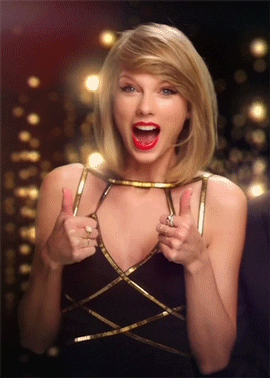

In [37]:
from IPython.core.display import Image as jImage
jImage(filename='/Users/jeff/work/last_frame.gif')

In [45]:
# save the whole thing
im.seek(0)
im.save('/Users/jeff/work/a-gif-we-found.gif',save_all=True,loop=1) #loop however many times you want, 0=forever

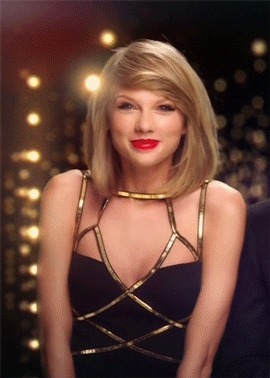

In [46]:
jImage(filename='/Users/jeff/work/a-gif-we-found.gif')